In [1]:
!pip3 freeze | grep torch

torch==1.7.1
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.7.0


In [2]:
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []
    
    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [3]:
from torch import nn

# from transformers import BertTokenizer, BertForSequenceClassification

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
# model.classifier = nn.Linear(768, 3, bias=True)

# from transformers import RobertaTokenizer, RobertaForSequenceClassification

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# model.classifier.out_proj = nn.Linear(768, 3, bias=True)

# from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-medium')
# tokenizer.pad_token = tokenizer.eos_token
# model = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-medium')
# # model
# model.score = nn.Linear(768, 3, bias=True)

# TweetBert
from transformers import AutoModel, AutoTokenizer, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base',
                                          use_fast=False, normalization=True)
# model = AutoModel.from_pretrained("vinai/bertweet-base")
model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base')
model.classifier.out_proj = nn.Linear(768, 3, bias=True)

# model

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSeq

In [26]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [4]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode
        
        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

#         # for gpt
#         text_list = tokenizer(text_list,
#                              truncation=True, padding=True,
#                              return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']
#         print(self.text_list[0])
#         print(self.mask_list[0])
        self.label_list = label_list
    
    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [5]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [25]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
tokenizer.convert_tokens_to_string(t)

"<s> @USER What 's up with the wait times on your customer service line ? Tried 2X on Fri . and now I 've been on for over 15 min . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>"

In [6]:
device = torch.device('cuda:2')

from torch import nn
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [7]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [8]:
from tqdm import tqdm

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)
#         print('t', text.shape)
#         print('m', mask.shape)
#         print('l', label.shape)

#         print('text', text)
        
        
        optimizer.zero_grad()
        output = model(text, mask)
#         print('output', output)
        pred = output.logits
#         print('pred', pred)
        loss = criterion(pred, label)
        acc = accuracy(pred, label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        output = model(text, mask)
        pred = output.logits
        loss = criterion(pred, label)
        acc = accuracy(pred, label)
        
        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

In [9]:
max_epoch = 3
log_interval = 1

best_acc = 0

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)
    
    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))
    
    torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))

    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 46/46 [00:01<00:00, 28.52it/s]


Epoch 1 train_loss: 0.008355377060212166 train_acc: 0.7883489461358314
Epoch 1 val_loss:  0.011141081824084449 val_acc : 0.8627049180327869


  0%|          | 0/161 [00:00<?, ?it/s]

---------- e 1 save best model ----------


100%|██████████| 46/46 [00:01<00:00, 27.99it/s]


Epoch 2 train_loss: 0.0048051938737374 train_acc: 0.8882708821233412
Epoch 2 val_loss:  0.011611906526600076 val_acc : 0.8668032786885246


  0%|          | 0/161 [00:00<?, ?it/s]

---------- e 2 save best model ----------


100%|██████████| 46/46 [00:01<00:00, 28.02it/s]


Epoch 3 train_loss: 0.003714838222972031 train_acc: 0.9181303669008587
Epoch 3 val_loss:  0.011412940298517546 val_acc : 0.8743169398907104
---------- e 3 save best model ----------


- bert lr1e-5 e5  
    0.8428 (e4)  
    0.8422 (e4)
- roberta b64 lr1e-5 e5   
    0.8545 (e3)  
    0.8558 (e3)  
    0.8579 (e5)  
- bertweet b64 lr1e-5 e5  
    0.8551  
    0.8736 (e2)  
    0.8715 (e4)  
    0.8715 (e5)  
    0.8743 (e3)

In [10]:
# torch.save(best_model.state_dict(), 'bertweet_m4.pt')

In [11]:
# ckpt = torch.load('ckpts/e5.pt')
# best_model.load_state_dict(ckpt)

In [12]:
# test(best_model, val_data, criterion)

In [13]:
for e in range(1, max_epoch + 1):
    print('epoch', e)
    ckpt = torch.load('ckpts/e{}.pt'.format(e))
    model.load_state_dict(ckpt)
    print(test(model, val_data, criterion))

epoch 1


100%|██████████| 46/46 [00:01<00:00, 27.70it/s]


(0.011141081824084449, 0.8627049180327869)
epoch 2


100%|██████████| 46/46 [00:01<00:00, 28.21it/s]


(0.011611906526600076, 0.8668032786885246)
epoch 3


100%|██████████| 46/46 [00:01<00:00, 28.07it/s]

(0.011412940298517546, 0.8743169398907104)


In [14]:
best_model.eval()

total_out = []
for text, mask in test_data:
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

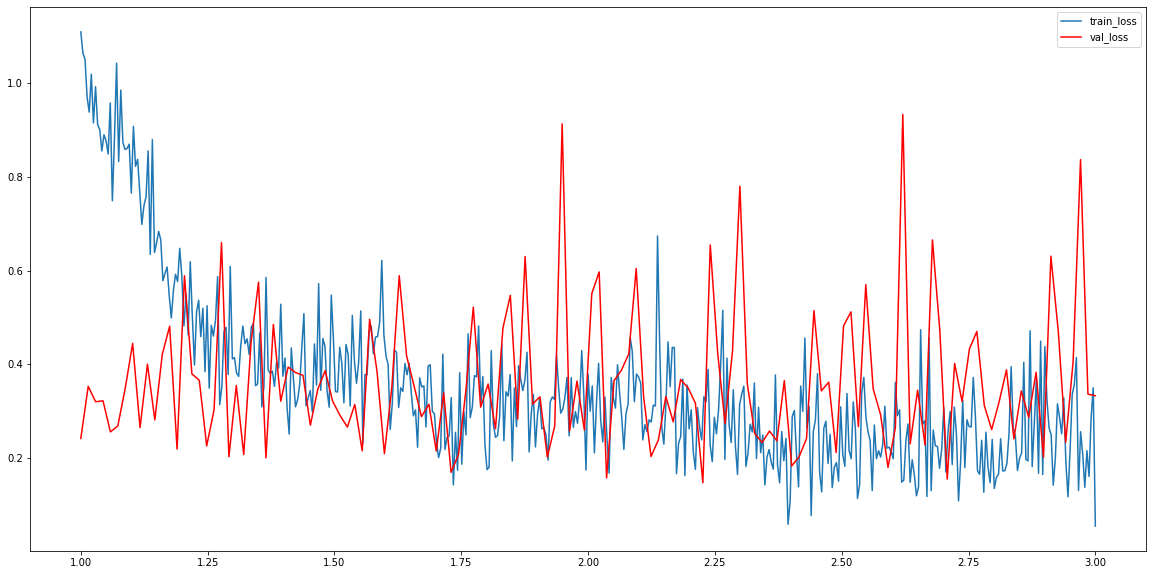

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

x1 = np.linspace(1, max_epoch, len(train_loss_list))
plt.plot(x1, train_loss_list)
x2 = np.linspace(1, max_epoch, len(val_loss_list))
plt.plot(x2, val_loss_list, color='r')
plt.legend(['train_loss', 'val_loss'])
plt.show()

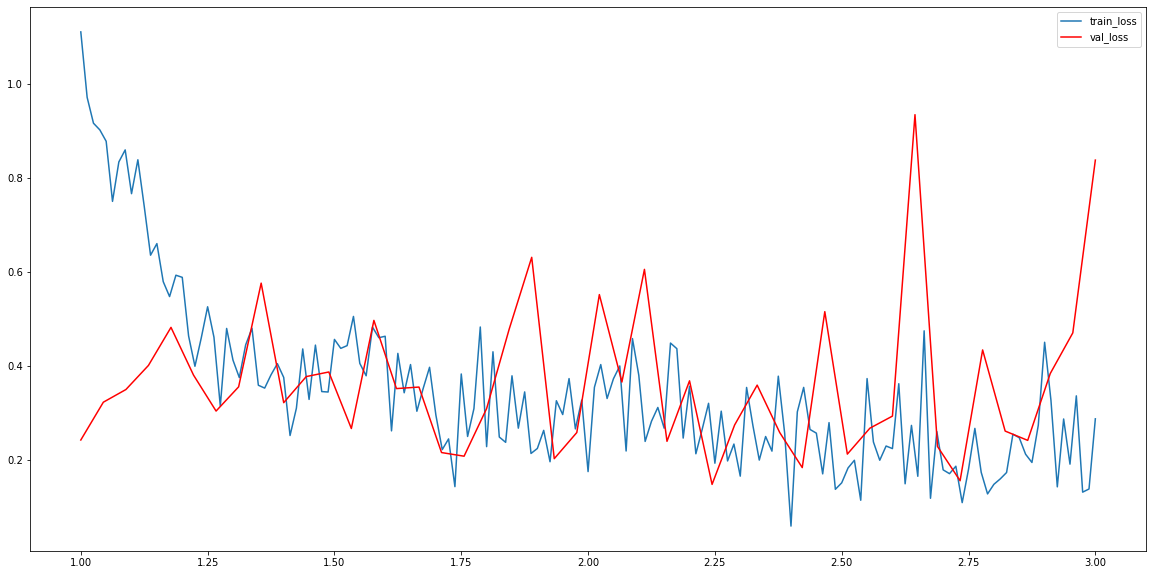

In [16]:
import matplotlib.pyplot as plt
import numpy as np

blur = 3

plt.figure(figsize=(20, 10))

small_train_loss = train_loss_list[::blur]
small_tval_loss = val_loss_list[::blur]

x1 = np.linspace(1, max_epoch, len(small_train_loss))
plt.plot(x1, small_train_loss)
x2 = np.linspace(1, max_epoch, len(small_tval_loss))
plt.plot(x2, small_tval_loss, color='r')
plt.legend(['train_loss', 'val_loss'])
plt.show()